# PREPARACION DE DATOS

En esta fase vamos a crear nuevas variables o transformar las existentes para poder dar mejor respuesta a nuestro objetivo.

Vamos a poner ejemplos tanto de como usar las variables internas como de cómo enriquecer con variables externas.

## SET UP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

#Automcompletar rápido
%config IPCompleter.greedy=True

pd.options.display.max_columns = None

## CARGA DE DATOS

In [2]:
con = sa.create_engine('sqlite:///../Datos/airbnb.db')

df = pd.read_sql('df', con = con)

df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,1,2,180,Excellent connection with the AIRPORT and EXHI...,t,2,1.0,1.0,80,4.87,4.89,4.77,5098,Chamartín
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,4,2,364,We have a quiet and sunny room with a good vie...,f,1,1.0,1.0,33,4.58,4.82,4.21,2267,Latina
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,15,5,222,"Apartamento de tres dormitorios dobles, gran s...",f,6,3.0,5.0,0,NaN,NaN,NaN,4085,Arganzuela
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,5,1,115,"Studio located 50 meters from Gran Via, next t...",f,3,1.0,1.0,12,4.92,5.00,5.00,4827,Centro
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,2,1,349,Nice and cozy roon for one person with a priva...,f,1,1.0,1.0,149,4.68,4.71,4.70,4085,Arganzuela


## PREPARACION DE VARIABLES

### Creacion de kpis de palancas

Primero vamos a crear las variables de análisis, es decir las que habíamos identificado como los Kpis que usaremos en las palancas que influyen sobre el negocio.

Habíamos dicho que eran 3:

* precio por noche: esta ya la tenemos directamente en la variable price, pero vamos a revisarla para ver que la entendemos bien
* ocupación: tenemos availability_365 pero hay que transformarla
* precio del inmueble: esta tendremos que crearla con variables externas así que la dejamos para después

**Empezamos con el precio.**

La documentación no aclara si el precio es por todo el inmueble, o si en el caso de que se alquile una habitación es por habitación.

Es un dato clave para poder hacer la valoración de los potenciales ingresos de un inmueble.

Vamos a intentar entenderlo analizando el precio medio por tipo de alquiler.

Es importante filtrar por solo un distrito para no incluir el efecto "zona".

Así que primero elegimos un distrito que tenga muchos datos.

In [3]:
df.distrito.value_counts()

Centro                   8127
Salamanca                1218
Chamberí                 1089
Arganzuela               1005
Tetuán                    762
Retiro                    618
Carabanchel               581
Chamartín                 538
Ciudad Lineal             532
Moncloa - Aravaca         493
Puente de Vallecas        465
San Blas - Canillejas     463
Latina                    455
Hortaleza                 354
Fuencarral - El Pardo     265
Usera                     233
Barajas                   142
Villaverde                129
Moratalaz                  94
Villa de Vallecas          90
Vicálvaro                  57
Name: distrito, dtype: int64

In [4]:
df.loc[df.distrito == 'Centro',:].groupby('room_type').price.mean()

room_type
Entire home/apt    148.859980
Private room        67.131643
Shared room         60.464286
Name: price, dtype: float64

Conclusión:
    
* alquilar el apartamento tiene un precio medio de 148€
* alquilar una habitación tiene un precio medio de 60€ o 67€ según sea compartida o privada
* por tanto para calcular los "ingresos" de un inmueble sí deberemos multiplicar el precio el precio por el número de habitaciones cuando sea de los tipos Private room o Shared room

Ahora bien, multiplicar el precio por el total de habitaciones puede sesgar artificialmente al alza la capacidad de generar ingresos de un inmueble.

Ya que si se alquila por habitaciones no es probable que siempre esté al 100%

Por tanto deberíamos ponderarlo por el porcentaje medio de habitaciones alquiladas.

No tenemos ese dato, pero supongamos que hemos hablado con el responsable de negocio y nos ha dicho que es del 70%.

Podemos crear la variable precio total aplicando apply sobre una función personalizada.

In [5]:
def crear_precio_total(registro):
    if (registro.beds > 1) & ((registro.room_type == 'Private room') | (registro.room_type == 'Shared room')):
        salida = registro.price * registro.beds * 0.7
    else:
        salida = registro.price
    return(salida)

df['precio_total'] = df.apply(crear_precio_total, axis = 1)

Comprobamos

In [6]:
df[['room_type','price','beds','precio_total']].head(30)

,room_type,price,beds,precio_total
0,Private room,60,1.0,60.0
1,Private room,31,1.0,31.0
2,Entire home/apt,50,5.0,50.0
3,Entire home/apt,92,1.0,92.0
4,Private room,26,1.0,26.0
5,Entire home/apt,85,3.0,85.0
6,Entire home/apt,65,2.0,65.0
7,Entire home/apt,54,1.0,54.0
8,Entire home/apt,1400,3.0,1400.0
9,Entire home/apt,81,2.0,81.0


**Ahora vamos con la ocupación**

La variable que tenemos que nos permite medir esto es availability_365.

Esta variable nos dice el número de días a un año vista que el inmueble NO está ocupado.

Por tanto nos interesaría transformarla a una medida más directa de ocupación, por ejemplo el % del año que SI está ocupada.

Podemos hacerlo con una tranformación directa.

In [7]:
df['ocupacion'] = ((365 - df.availability_365) / 365 * 100).astype('int')
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito,precio_total,ocupacion
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,1,2,180,Excellent connection with the AIRPORT and EXHI...,t,2,1.0,1.0,80,4.87,4.89,4.77,5098,Chamartín,60.0,50
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,4,2,364,We have a quiet and sunny room with a good vie...,f,1,1.0,1.0,33,4.58,4.82,4.21,2267,Latina,31.0,0
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,15,5,222,"Apartamento de tres dormitorios dobles, gran s...",f,6,3.0,5.0,0,NaN,NaN,NaN,4085,Arganzuela,50.0,39
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,5,1,115,"Studio located 50 meters from Gran Via, next t...",f,3,1.0,1.0,12,4.92,5.00,5.00,4827,Centro,92.0,68
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,2,1,349,Nice and cozy roon for one person with a priva...,f,1,1.0,1.0,149,4.68,4.71,4.70,4085,Arganzuela,26.0,4


### Transformación de varaibles de análisis

Algunas de las preguntas semilla están dirigidas a comprobar cómo se comporta el precio o la ocupación según otras variables como el número de habitaciones, la media de valoraciones, etc.

Normalmente podremos hacer mejor estos análisis si discretizamos la variable de análisis.

En nuestro caso las candidatas para este análisis son: accommodates, bedrooms, beds y number_of_reviews.

En bedrooms tiene sentido una discretización más personalizada. En las otras podemos hacerla automática.

**Discretizar bedrooms**

Comenzamos por evaluar la distribución de los datos.

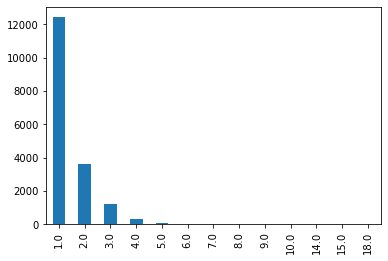

In [8]:
df.bedrooms.value_counts().plot.bar();

Vamos a discretizar para 1,2,3 y más de 3.

Podemos usar np.select

In [9]:
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms > 3]

resultados = ['01_Una','02_Dos','03_Tres','04_Cuatro o mas']

df['bedrooms_disc'] = np.select(condiciones, resultados, default = -999)

Comprobamos

In [10]:
df.bedrooms_disc.value_counts()

01_Una             12422
02_Dos              3617
03_Tres             1228
04_Cuatro o mas      443
Name: bedrooms_disc, dtype: int64

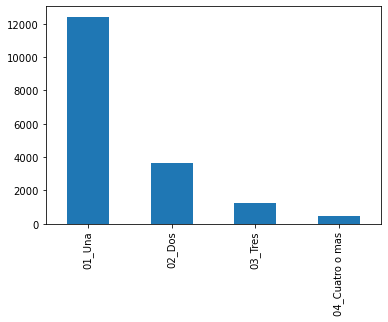

In [11]:
df.bedrooms_disc.value_counts().plot.bar();

**Discretizar accommodates, beds y number_of_reviews**

Vamos a usar qcut para discritizar con percentiles 0.5, 0.8, 1

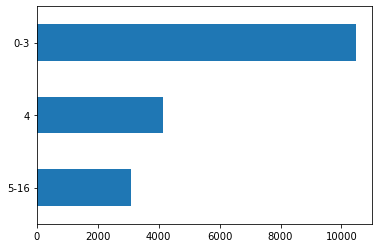

In [28]:
df['accommodates_disc'] = pd.qcut(df.accommodates,[0, 0.5, 0.8, 1],
                                 labels = ['0-3','4','5-16'])

df['accommodates_disc'].value_counts().sort_index(ascending = False).plot.barh();

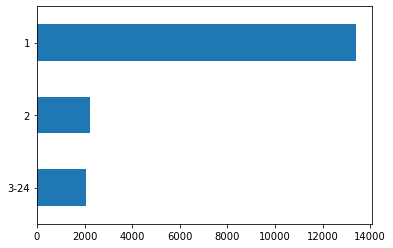

In [13]:
df['beds_disc'] = pd.qcut(df.beds,[0, 0.5, 0.8, 1],
                         labels = ['1','2','3-24'])

df['beds_disc'].value_counts().sort_index(ascending = False).plot.barh();

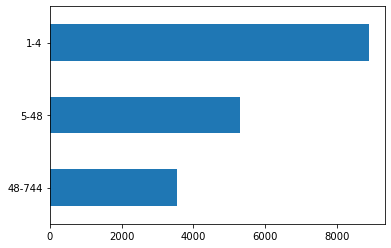

In [14]:
df['number_of_reviews_disc'] = pd.qcut(df.number_of_reviews,[0, 0.5, 0.8, 1],
                                      labels = ['1-4','5-48','48-744'])

df['number_of_reviews_disc'].value_counts().sort_index(ascending = False).plot.barh();

### Creación de variables con datos externos

En este caso en concreto se podrían hacer muchas cosas con datos externos.

Lo primero, que ya hemos incorporado parcialmente, es la palanca del precio del inmueble.

Decíamos que la podíamos estimar multiplicando los metros cuadrados del inmueble por el precio por m2.

El precio_m2 ya lo hemos conseguido, pero el tamaño del inmueble no lo tenemos en los datos.

Lo que podemos hacer es establecer unos criterios en base al número de habitaciones.

No es perfecto, pero nos servirá de aproximación.

**Estimación de los metros cuadrados del inmueble**

Vamos usar el siguiente algoritmo:

* una habitación: m2 = 50
* dos habitaciones: m2 = 70
* tres habitaciones: m2 = 90
* cuatro habitaciones: m2 = 120
* cinco o más habitaciones: m2 = 150

In [15]:
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms == 4,
               df.bedrooms > 4]

resultados = [50,70,90,120,150]

df['m2'] = np.select(condiciones, resultados, default = -999)

Comprobamos

In [16]:
df['m2'].value_counts()

50     12422
70      3617
90      1228
120      296
150      147
Name: m2, dtype: int64

Ahora ya podemos estimar el precio de compra del inmueble.

Recordamos que al precio que nos sale le quitábamos un 30% por capacidad de negociación.

In [17]:
df['precio_compra'] = df.m2 * df.precio_m2 * 0.7

Comprobamos

In [18]:
df[['bedrooms','m2','distrito','precio_m2','precio_compra']].head(20)

,bedrooms,m2,distrito,precio_m2,precio_compra
0,1.0,50,Chamartín,5098,178430.0
1,1.0,50,Latina,2267,79345.0
2,3.0,90,Arganzuela,4085,257355.0
3,1.0,50,Centro,4827,168945.0
4,1.0,50,Arganzuela,4085,142975.0
5,3.0,90,Arganzuela,4085,257355.0
6,1.0,50,Centro,4827,168945.0
7,1.0,50,Centro,4827,168945.0
8,2.0,70,Centro,4827,236523.0
9,1.0,50,Centro,4827,168945.0


Ahora vamos a poner un ejemplo de qué otro tipo de variables podemos construir.

En este caso podríamos hacer mucho con las coordenadas x,y.

Ya que en turismo la localización es muy importante.

Por ejemplo podríamos calcular las distancias a diferentes puntos de interés como monumentos, lugares de ocio, recintos deportivos, etc.

Simplemente como ejemplo vamos a calcular la distancia de cada inmueble a la Puerta del Sol.

Para ello buscamos en Google su longitud y latitud: https://www.123coordenadas.com/coordinates/81497-puerta-del-sol-madrid

Latitud: 40.4167278
Longitud: -3.7033387

**Cálculo de la distancia de cada inmueble a la Puerta del Sol**

Dada la curvatura de la tierra la distancia entre dos puntos a partir de su latitud y longitud se calcula con una fórmula que se llama distancia de Haversine.

Una búsqueda en Google nos da una función ya construída para calcularla que podemos adaptar: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [19]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 #En km, si usas millas tienes que cambiarlo por 3959.87433

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

Creamos la variable

In [20]:
#Las coordenadas de la Puerta del Sol serán lat1 y lon1
lat1 = 40.4167278
lon1 = -3.7033387

df['pdi_sol'] = df.apply(lambda registro: haversine(lat1,lon1,registro.latitude,registro.longitude),axis = 1)

Comprobamos revisando la distancia media por distritos.

In [21]:
df.groupby('distrito').pdi_sol.mean().sort_values()

distrito
Centro                    0.730611
Arganzuela                1.939114
Chamberí                  2.133167
Retiro                    2.450593
Salamanca                 2.715975
Moncloa - Aravaca         3.294526
Usera                     3.928874
Latina                    3.942634
Carabanchel               3.970238
Chamartín                 4.432842
Puente de Vallecas        4.481127
Tetuán                    4.624605
Moratalaz                 5.073901
Ciudad Lineal             5.231293
Villaverde                7.664192
Fuencarral - El Pardo     8.062301
Hortaleza                 8.074184
San Blas - Canillejas     8.199011
Vicálvaro                 8.599559
Villa de Vallecas         9.176618
Barajas                  11.439064
Name: pdi_sol, dtype: float64

## GUARDAMOS EN EL DATAMART

Vamos a guardar esta version como df_preparado

In [22]:
df.to_sql('df_preparado', con = con, if_exists = 'replace')

17710